In [1]:
import scipy.io
import seaborn as sns
import numpy as np
import ddm.plot
import matplotlib.pyplot as plt
import pandas as pd
import ddm.models
from itertools import product
from ddm import Sample, Model, Fittable, Solution
from ddm.functions import fit_adjust_model, display_model, fit_model, dependence_hit_boundary
from ddm.models import DriftConstant, NoiseConstant, BoundConstant, LossRobustBIC, OverlayChain, OverlayNonDecision, OverlayPoissonMixture
import os, sys 
from scipy import stats
from scipy.stats import zscore
from scipy.stats import ttest_ind

In [2]:
df = pd.read_csv("/Users/terlau/LNDG/EyeMem/EyeMem_1/DDM/EyeMem_hddm_test.csv")
# Clean from Invalid Reaction Times 
data=df.loc[~df['rt'].isnull()]
print(data)
data['z_rt'] = stats.zscore(data['rt'])
data = data[np.abs(data['z_rt']) < 3]
#data = data[np.abs(data['rt']-data['rt'].mean()) <= (3*data['rt'].std())]
# keep only the ones that are within +3 to -3 standard deviations

data['rt'] = data[data["rt"] < .25] # Remove trials less than 100ms
#data['rt'] = data[data["rt"] > 1.65] # Remove trials greater than 1650ms
SubjectList = np.unique(data['subj_idx'])
data

       subj_idx  category  stim  response  accuracy     rt  age
0             9         3     1       2.0         1  0.739    0
1             9         3     1       2.0         1  0.859    0
2             9         3     1       1.0         0  0.716    0
3             9         3     0       1.0         0  1.153    0
4             9         3     0       2.0         0  0.665    0
...         ...       ...   ...       ...       ...    ...  ...
26007       101         3     0       2.0         1  1.008    1
26008       101         3     1       1.0         1  0.838    1
26009       101         3     1       1.0         1  0.609    1
26010       101         3     0       1.0         0  0.712    1
26011       101         3     0       2.0         1  0.884    1

[25846 rows x 7 columns]


<ipython-input-2-051e8d81c7a6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['z_rt'] = stats.zscore(data['rt'])


,subj_idx,category,stim,response,accuracy,rt,age,z_rt
0,9,3,1,2.0,1,0.739,0,-0.796713
1,9,3,1,2.0,1,0.859,0,-0.455187
2,9,3,1,1.0,0,0.716,0,-0.862172
3,9,3,0,1.0,0,1.153,0,0.381551
4,9,3,0,2.0,0,0.665,0,-1.007320
...,...,...,...,...,...,...,...,...
26007,101,3,0,2.0,1,1.008,1,-0.031126
26008,101,3,1,1.0,1,0.838,1,-0.514954
26009,101,3,1,1.0,1,0.609,1,-1.166699
26010,101,3,0,1.0,0,0.712,1,-0.873556


2.072
0.231
2.9970678791508854
-2.2425042957856283
[1. 2.]
age
0    1.057011
1    0.953713
Name: rt, dtype: float64
age
0    0.739870
1    0.672684
Name: accuracy, dtype: float64


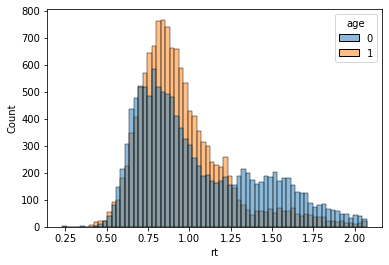

In [3]:
print(data['rt'].max())
print(data['rt'].min())
print(data['z_rt'].max())
print(data['z_rt'].min())
#data = data.dropna()
#data = data.reset_index(drop=True)
#print(data)
#data=data.loc[~data['response'].isnull()] # response has a lot of nan values only for study (around 800-900)
#data = data.reset_index(drop=True)
#print(data)
print(np.unique(data['response']))
df_age= data.groupby('age')
print(df_age['rt'].mean())
print(df_age['accuracy'].mean())
sns.histplot(data=data, x="rt", hue="age")
plt.show()


In [4]:
data.isnull().sum()

subj_idx    0
category    0
stim        0
response    0
accuracy    0
rt          0
age         0
z_rt        0
dtype: int64

In [16]:
def setup_model():
    """
    Function to setup model. 
    """
    model = Model(name='Simple model',
            drift=DriftConstant(drift=Fittable(minval=0, maxval=4)),
            noise=NoiseConstant(noise=1),
            #bound = BoundCollapsingExponential(B=Fittable(minval=0.5, maxval=3),tau=Fittable(minval=.0001,maxval=5)),
            bound=BoundConstant(B=Fittable(minval=0.1, maxval=1)),
            #IC=ICRange(sz=.2),
            overlay=OverlayNonDecision(nondectime=Fittable(minval=0, maxval=.8)),
            dx=.01, dt=.01, T_dur=2.5)      
      
    return model


Analytic solutions are only possible in a select number of special cases; in particular, it works for simple DDM and for linearly collapsing bounds and arbitrary single-point initial conditions. (See Anderson (1960) for implementation details.) For most reasonably complex models, the method will fail. Check whether a solution is possible with has_analytic_solution()

In [6]:
pwd

'/Users/terlau/LNDG/EyeMem/PyDDM'

In [17]:
#import ddm.plot
from ddm.models import BoundCollapsingExponential
from ddm.models import ICRange
subjects = []
drift = []
#noise = []
boundary = []
nondectime = []
fit = []
loss = []
age = []

#fig, axes = plt.subplots(nrows=16, ncols=5, figsize = (70,50))
#fig.subplots_adjust(hspace=0.5)
#fig.suptitle('PyDDM Fits YA', fontsize=20)


#for ax, name in zip(axes.flatten(), SubjectList):
 #   print(name)
    
for sub in SubjectList:
   
    sub_df = data[data['subj_idx'] == sub]

   # Load Data
    sample = Sample.from_pandas_dataframe(sub_df, rt_column_name="rt", correct_column_name="accuracy")
    print("mean decision time", sample.mean_decision_time())
   # print(sample.condition_combinations())
    print(sample.condition_names())
    print(sample.prob_correct(), sample.prob_error())
    print(sample.prob_undecided())
   # print(sample.corr) # RT for correct trials
   # plt.plot(sample.corr)
   # plt.plot(sample.err)
   # plt.show()
   
    #print("correct + error component of the joint CDF")
   # plt.plot(sample.cdf_corr())
   # plt.plot(sample.cdf_err())
   # plt.show()
    
    
 
    # Set up and fit ddm model
    simple_model = setup_model()
    print(simple_model.has_analytical_solution()) #False if collapsing bounds, can't apply solve function to this model then
    print(simple_model.can_solve_cn()) # False if collapsing bounds, solving numerically with Crank-Nicolson won't work then
    
    
    fit_model = fit_adjust_model(sample=sample, model=simple_model, lossfunction=LossRobustBIC, verbose=False)
    print("Fitted", fit_model.get_fit_result())

    print(sub)
    print(np.unique(sub_df['category']))

    age.append(np.unique(sub_df['age'])[0])
    subjects.append(np.unique(sub_df['subj_idx'])[0])
    drift.append(float(simple_model.get_model_parameters()[0]))
   # noise.append(float(simple_model.get_model_parameters()[1])) 
    boundary.append(float(simple_model.get_model_parameters()[1]))
    nondectime.append(float(simple_model.get_model_parameters()[2]))
    fit.append(simple_model.fitresult.value())
    loss.append(simple_model.fitresult.loss)
    s = fit_model.solve()
    print("correct RTs prob", s.prob_correct()) #float
   

    ddm.plot.plot_fit_diagnostics(model=fit_model, sample=sample)
    plt.savefig('/Users/terlau/ddm_plots/no_noise_test1_eyemem1_sub_{}.png'.format(sub))
   # plt.show()
    plt.close()
   # display_model(fit_model)
   # if all(sub_df['age']==0):
       # ddm.plot.plot_fit_diagnostics(model=fit_model, sample=sample)
        #plt.show()
       # ddm.plot.model_gui_jupyter(model=fit_model, sample=sample)

   
        
#'noise': noise, 
fit_dict= {'subjects': subjects, 'age': age, 'drift': drift,'boundary': boundary, 'nondec': nondectime, 'fit': fit, 'loss': loss} 
fit_df = pd.DataFrame(fit_dict)

    

mean decision time 0.7958405172413793
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7759197324414716 0.22408026755852842
0.0
True
True
Params [1.20097566 0.5770516  0.54328826] gave 20.602885091350775
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=20.602885091350775, nparams=3, samplesize=299, mess='')
9
[1 2 3 4 5]
correct RTs prob 0.7997822372695803
mean decision time 0.799344978165939
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7658862876254181 0.23411371237458195
0.0
True
True
Params [1.10173532 0.58870082 0.53299492] gave 74.44078355794154
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=74.44078355794154, nparams=3, samplesize=299, mess='')
10
[1 2 3 4 5]
correct RTs prob 0.785082473925836
mean decision time 0.909747619047619
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.711864406779661 0.288135593220339
0.0
True
True
Params [0.79355991 0.6057085

Params [1.09343212 0.67393337 0.54020178] gave 163.224643276118
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=163.224643276118, nparams=3, samplesize=297, mess='')
31
[1 2 3 4 5]
correct RTs prob 0.8120151237447802
mean decision time 1.5404271844660196
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7686567164179104 0.23134328358208955
0.0
True
True
Params [0.70904524 1.         0.79794608] gave 554.0687647350113
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=554.0687647350113, nparams=3, samplesize=268, mess='')
32
[1 2 3 4 5]
correct RTs prob 0.720866883136829
mean decision time 0.9750635593220339
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7892976588628763 0.21070234113712374
0.0
True
True
Params [0.93344321 0.74432654 0.54368222] gave 361.57729144612836
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=361.57729144612836, 

Params [0.37330156 0.71404285 0.51894557] gave 453.9095560462481
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=453.9095560462481, nparams=3, samplesize=294, mess='')
51
[1 2 3 4 5]
correct RTs prob 0.6245779899509926
mean decision time 0.8727551867219917
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.8060200668896321 0.1939799331103679
0.0
True
True
Params [1.1149855  0.70597475 0.51654815] gave 225.77050381608694
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=225.77050381608694, nparams=3, samplesize=299, mess='')
52
[1 2 3 4 5]
correct RTs prob 0.8260777876207769
mean decision time 1.00940234375
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.8619528619528619 0.13804713804713806
0.0
True
True
Params [1.18299858 0.79695589 0.55365252] gave 321.6222090851932
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=321.6222090851932, npa

Params [0.59397945 0.79774448 0.48573833] gave 502.8212192292331
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=502.8212192292331, nparams=3, samplesize=280, mess='')
74
[1 2 3 4 5]
correct RTs prob 0.7077131465420118
mean decision time 0.8163333333333335
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.5896551724137931 0.4103448275862069
0.0
True
True
Params [0.31044103 0.62894658 0.46908996] gave 301.9395335075787
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=301.9395335075787, nparams=3, samplesize=290, mess='')
75
[1 2 3 4 5]
correct RTs prob 0.5952300212146362
mean decision time 1.534679012345679
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.574468085106383 0.425531914893617
0.0
True
True
Params [0.15313934 1.         0.59665727] gave 845.4504794724464
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=845.4504794724464, npar

Params [0.78949387 0.68680486 0.57053957] gave 316.36839291944
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=316.36839291944, nparams=3, samplesize=298, mess='')
94
[1 2 3 4 5]
correct RTs prob 0.7439428015811526
mean decision time 1.4308341013824883
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7722419928825622 0.2277580071174377
0.0
True
True
Params [0.57507983 1.         0.50859388] gave 749.1189946309745
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=749.1189946309745, nparams=3, samplesize=281, mess='')
95
[1 2 3 4 5]
correct RTs prob 0.6991787008369436
mean decision time 0.9961416309012876
['subj_idx', 'category', 'stim', 'response', 'age', 'z_rt']
0.7818791946308725 0.2181208053691275
0.0
True
True
Params [1.03970417 0.67716932 0.64294634] gave 217.25442642918892
Fitted FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=217.25442642918892, npa

In [18]:
fit_df.to_pickle('fitted_pyddm_no_noise_test') 
fit_df

,subjects,age,drift,boundary,nondec,fit,loss
0,9,0,1.200976,0.577052,0.543288,20.602885,BIC
1,10,0,1.101735,0.588701,0.532995,74.440784,BIC
2,12,1,0.793560,0.605709,0.614721,198.395852,BIC
3,13,1,0.381267,0.655162,0.652545,356.526837,BIC
4,14,1,0.651819,0.633925,0.491802,224.213605,BIC
...,...,...,...,...,...,...,...
83,97,0,0.547720,0.672271,0.493819,369.226163,BIC
84,98,0,0.562414,0.563988,0.481032,141.541256,BIC
85,99,1,0.357717,0.626064,0.464508,264.158981,BIC
86,100,1,0.362241,0.579261,0.573208,192.455975,BIC


In [20]:
#simple_fit = pd.read_pickle('fitted_pyddm_test_age')
#simple_fit
#constant_noise = pd.read_pickle('fitted_pyddm_constant_noise_test')
#constant_noise
#no_noise = pd.read_pickle('fitted_pyddm_no_noise_test')
#no_noise.nlargest(10,['nondec'])

,subjects,drift,noise,boundary,nondec,fit,loss
0,9,1.754711,1.461068,0.843112,0.545766,26.303329,BIC
1,10,1.668257,1.514211,0.891417,0.538445,80.141227,BIC
2,12,1.011405,1.274515,0.771985,0.610545,204.082827,BIC
3,13,0.277174,0.726990,0.476296,0.651479,362.217196,BIC
4,14,0.398941,0.612047,0.387992,0.497894,229.883486,BIC
...,...,...,...,...,...,...,...
83,97,0.554727,1.012794,0.680872,0.490439,374.923256,BIC
84,98,0.783923,1.393938,0.786163,0.480330,147.238349,BIC
85,99,0.532684,1.489128,0.932289,0.462354,269.859424,BIC
86,100,0.575201,1.587900,0.919808,0.578974,198.146334,BIC


In [10]:
ya_df = no_noise.loc[no_noise['age'] == 0]
oa_df = no_noise.loc[no_noise['age'] == 1]
print(ya_df.describe())
print(oa_df.describe())
oa_n = 45
ya_n = 43
N = (oa_n+ya_n)/2
print(N)
print(ya_df.head())
oa_df.head()

        subjects   age      drift   boundary     nondec         fit
count  43.000000  43.0  43.000000  43.000000  43.000000   43.000000
mean   57.697674   0.0   0.780300   0.778624   0.550005  385.572284
std    25.612994   0.0   0.303663   0.153158   0.122547  212.143482
min     9.000000   0.0   0.028588   0.544194   0.209855   20.602885
25%    41.500000   0.0   0.602597   0.670649   0.484012  217.648794
50%    59.000000   0.0   0.749688   0.751556   0.532562  369.226163
75%    76.500000   0.0   0.984518   0.932634   0.588420  553.007693
max    98.000000   0.0   1.517162   1.000000   0.796290  845.450479
         subjects   age      drift   boundary     nondec         fit
count   45.000000  45.0  45.000000  45.000000  45.000000   45.000000
mean    53.466667   1.0   0.590414   0.683487   0.543030  328.247345
std     28.312060   0.0   0.267678   0.092466   0.089063  154.718681
min     12.000000   1.0   0.063321   0.556342   0.309560   81.763792
25%     29.000000   1.0   0.378879   0.6260

,subjects,age,drift,boundary,nondec,fit,loss
2,12,1,0.793560,0.605709,0.616006,198.395852,BIC
3,13,1,0.381267,0.655162,0.650981,356.526837,BIC
4,14,1,0.651818,0.633925,0.499478,224.213605,BIC
6,16,1,0.424158,0.809968,0.424721,530.124279,BIC
10,21,1,0.898186,0.746009,0.539978,321.519826,BIC


In [11]:
def two_sample_t_test(a,b, N):
    
## Calculate the Standard Deviation
#Calculate the variance to get the standard deviation

    #For unbiased max likelihood estimate we have to divide the var by N-1, and therefore the parameter ddof = 1
    var_oa = a.var(ddof=1)
    var_ya = b.var(ddof=1)

    #std deviation
    s = np.sqrt((var_oa + var_ya)/2)
    #print(s)

    

    ## Calculate the t-statistics
    t = (a.mean() - b.mean())/(s*np.sqrt(2/N))



    ## Compare with the critical t-value
    #Degrees of freedom
    df = 2*N - 2

    #p-value after comparison with the t 
    p = 1 - stats.t.cdf(t,df=df) #1- for negative t-values!


    print("t = " + str(t))
    print("p = " + str(2*p))
  


    ## Cross Checking with the internal scipy function
    t2, p2 = stats.ttest_ind(a,b)
    print("t = " + str(t2))
    print("p = " + str(p2))

In [12]:
two_sample_t_test(ya_df['drift'],oa_df['drift'], N)
two_sample_t_test(ya_df['boundary'],oa_df['boundary'], N)
two_sample_t_test(ya_df['nondec'],oa_df['nondec'], N)
#two_sample_t_test(ya_df['noise'],oa_df['noise'], N)
two_sample_t_test(ya_df['fit'],oa_df['fit'], N)

t = 3.1115801690979805
p = 0.002525597474716923
t = 3.1153248187387037
p = 0.0024969972066275392
t = 3.527382400090561
p = 0.0006759967244582832
t = 3.545726339747394
p = 0.0006362731689052558
t = 0.30542233487179626
p = 0.7607825387206169
t = 0.30644556030814807
p = 0.7600061132954288
t = 1.4481905506666632
p = 0.15119985460854624
t = 1.4529884000174669
p = 0.14986617173927835


In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

sns.set(style="whitegrid")


sns.barplot(x="age", y="drift", data=constant_noise,  capsize=.1, color='lightblue') # ci="sd"
sns.swarmplot(x="age", y="drift", data=constant_noise, color="0", alpha=.35)
# show the mean
for p in ax.patches:
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2., h / 2)
    text = f'Mean:\n{h:0.2f}'
    ax.annotate(text=text, xy=xy, ha='center', va='center')

# statistical annotation
x1, x2 = 0, 1   
y, h, col = constant_noise['drift'].max()+0.09,0.09, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
plt.text((x1+x2)*.5, y+h, "p-val 0.0024", ha='center', va='bottom', color=col)
plt.title("Simple PyDDM (noise = 1) OA vs YA Drift")
plt.savefig('/Users/terlau/ddm_plots/constant_noise_test1_eyemem1_drift.png')
plt.show()



In [ ]:
sns.pointplot(x ='age', y = 'drift', 
    data=constant_noise, dodge=True, join=False)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

sns.set(style="whitegrid")


sns.barplot(x="age", y="boundary", data=constant_noise,  capsize=.1, color='lightblue') # ci="sd"
sns.swarmplot(x="age", y="boundary", data=constant_noise, color="0", alpha=.35)
# show the mean
for p in ax.patches:
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2., h / 2)
    text = f'Mean:\n{h:0.2f}'
    ax.annotate(text=text, xy=xy, ha='center', va='center')

# statistical annotation
x1, x2 = 0, 1   
y, h, col = constant_noise['boundary'].max()+0.09,0.09, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
plt.text((x1+x2)*.5, y+h, "p-val 0.00062", ha='center', va='bottom', color=col)
plt.title("Simple PyDDM (noise = 1) OA vs YA Boundary")
plt.savefig('/Users/terlau/ddm_plots/constant_noise_test1_eyemem1_boundary.png')
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

sns.set(style="whitegrid")


sns.barplot(x="age", y="nondec", data=constant_noise,  capsize=.1, color='lightblue') # ci="sd"
sns.swarmplot(x="age", y="nondec", data=constant_noise, color="0", alpha=.35)
# show the mean
for p in ax.patches:
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2., h / 2)
    text = f'Mean:\n{h:0.2f}'
    ax.annotate(text=text, xy=xy, ha='center', va='center')


# statistical annotation
x1, x2 = 0, 1   
y, h, col = constant_noise['nondec'].max()+0.09,0.09, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
plt.text((x1+x2)*.5, y+h, "p-val 0.736", ha='center', va='bottom', color=col)
plt.title("Simple PyDDM (noise = 1) OA vs YA NonDec")
plt.savefig('/Users/terlau/ddm_plots/constant_noise_test1_eyemem1_nondec.png')
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

sns.set(style="whitegrid")


sns.barplot(x="age", y="fit", data=constant_noise,  capsize=.1, color='lightblue') # ci="sd"
sns.swarmplot(x="age", y="fit", data=constant_noise, color="0", alpha=.35)
# show the mean
for p in ax.patches:
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2., h / 2)
    text = f'Mean:\n{h:0.2f}'
    ax.annotate(text=text, xy=xy, ha='center', va='center')


# statistical annotation
x1, x2 = 0, 1   
y, h, col = constant_noise['fit'].max()+4,0.1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
plt.text((x1+x2)*.5, y+h, "p-val 0.15", ha='center', va='bottom', color=col)
plt.title("Simple PyDDM (noise = 1) OA vs YA Fit")
plt.savefig('/Users/terlau/ddm_plots/constant_noise_test1_eyemem1_fit.png')
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

sns.set(style="whitegrid")


sns.barplot(x="age", y="noise", data=simple_fit,  capsize=.1, color='lightblue') # ci="sd"
sns.swarmplot(x="age", y="noise", data=simple_fit, color="0", alpha=.35)
# show the mean
for p in ax.patches:
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2., h / 2)
    text = f'Mean:\n{h:0.2f}'
    ax.annotate(text=text, xy=xy, ha='center', va='center')


plt.show()

In [ ]:
fit_1 = pd.read_pickle('fitted_pyddm_test_1')
fit_2 = pd.read_pickle('fitted_pyddm_test_2')

In [ ]:
fit_1['fit_diff'] = np.where(fit_1['fit'] == fit_2['fit'], 0, fit_1['fit'] - fit_2['fit'])
fit_1.describe()

In [ ]:
print("Drift:", fit_1['drift'].corr(fit_2['drift']))
plt.scatter(fit_1['drift'], fit_2['drift'])
plt.show()

In [ ]:
print("Noise:", fit_1['noise'].corr(fit_2['noise']))
plt.scatter(fit_1['noise'], fit_2['noise'])
plt.show()

In [ ]:
print("Boundary:", fit_1['boundary'].corr(fit_2['boundary']))
plt.scatter(fit_1['boundary'], fit_2['boundary'])
plt.show()

In [ ]:
print("Non-descision time:", fit_1['nondec'].corr(fit_2['nondec']))
plt.scatter(fit_1['nondec'], fit_2['nondec'])
plt.show()

In [ ]:
print("Fit:", fit_1['fit'].corr(fit_2['fit']))
plt.scatter(fit_1['fit'], fit_2['fit'])
plt.show()

In [ ]:
    
    def fit_group_ddm(self, cpus):
        """
        Fits a separate ddm to all subjects and colors. 
        Saves fitting results to result file.
        """
        # Computes fitting for each category in parallel
        with Pool(processes=cpus) as p: 
            white_results = p.starmap(self.fit_single_ddm, zip(self.SubjectList,['white']*len(self.SubjectList)))
            blue_results = p.starmap(self.fit_single_ddm, zip(self.SubjectList,['blue']*len(self.SubjectList)))
            pink_results = p.starmap(self.fit_single_ddm, zip(self.SubjectList,['pink']*len(self.SubjectList)))
        
        # Put results into one DataFrame
        results_list = []
        for results, color in zip([white_results, blue_results, pink_results], self.noisecolors):
            results = pd.DataFrame(results)
            results['noise_color'] = color
            results['ID'] = self.SubjectList
            results_list.append(results)
        results_df = pd.concat(results_list)
        # Save to File
        results_df.to_csv(self.resultfile)

In [ ]:
# Create a sample object from our data.  This is the standard input
# format for fitting procedures.  Since RT and correct/error are
# both mandatory columns, their names are specified by command line
# arguments.
test_sample = Sample.from_pandas_dataframe(df_rt, rt_column_name="rt", correct_column_name="accuracy")

In [ ]:

#drift rate vary with the stim (ie if target present or not) as drift represents evidence and this differes dependent on stim
#how do we include age or category?
class DriftCoherence(ddm.models.Drift):
    name = "Drift depends linearly on coherence"
    required_parameters = ["driftcoh"] # <-- Parameters we want to include in the model
    required_conditions = ["stim"] # <-- Task parameters ("conditions"). Should be the same name as in the sample.
    
    # We must always define the get_drift function, which is used to compute the instantaneous value of drift.
    def get_drift(self, conditions, **kwargs):
        return self.driftcoh * conditions['stim']


In [ ]:

model_rs = Model(name='test data, drift varies with stim',
                 drift=DriftCoherence(driftcoh=Fittable(minval=0, maxval=20)),
                 noise=NoiseConstant(noise=1),
                 bound=BoundConstant(B=Fittable(minval=.1, maxval=1.5)),
                 # Since we can only have one overlay, we use
                 # OverlayChain to string together multiple overlays.
                 # They are applied sequentially in order.  OverlayNonDecision
                 # implements a non-decision time by shifting the
                 # resulting distribution of response times by
                 # `nondectime` seconds.
                 overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fittable(minval=0, maxval=.4)),
                                                OverlayPoissonMixture(pmixturecoef=.02,
                                                                      rate=1)]),
                 dx=.001, dt=.01, T_dur=2)

# Fitting this will also be fast because PyDDM can automatically
# determine that DriftCoherence will allow an analytical solution.
fit_model_rs = fit_adjust_model(sample=test_sample, model=model_rs, verbose=False)


In [ ]:
display_model(fit_model_rs)

In [ ]:
import ddm.plot
import matplotlib.pyplot as plt
ddm.plot.plot_fit_diagnostics(model=fit_model_rs, sample=test_sample)
#plt.savefig("roitman-fit.png")
plt.show()


In [ ]:
df

In [ ]:
# compute T_dur:
T_dur = df['rt'].max()+1
T_dur 

In [ ]:
pwd

In [ ]:

m = Model()
s = m.solve()
plt.plot(s.model.t_domain(), s.pdf_corr())
#plt.savefig("helloworld.png")
plt.show()


In [ ]:

model = Model(name='Simple model',
              drift=DriftConstant(drift=2.2),
              noise=NoiseConstant(noise=1.5),
              bound=BoundConstant(B=1.1),
              overlay=OverlayNonDecision(nondectime=.1),
              dx=.001, dt=.01, T_dur=2)
display_model(model)
sol = model.solve()

In [ ]:
#generate psuedo-data from this solved model with the resample() function
samp = sol.resample(1000)

In [ ]:

model_fit = Model(name='Simple model (fitted)',
                  drift=DriftConstant(drift=Fittable(minval=0, maxval=4)),
                  noise=NoiseConstant(noise=Fittable(minval=.5, maxval=4)),
                  bound=BoundConstant(B=1.1),
                  overlay=OverlayNonDecision(nondectime=Fittable(minval=0, maxval=1)),
                  dx=.001, dt=.01, T_dur=2)

fit_adjust_model(samp, model_fit,
                 fitting_method="differential_evolution",
                 lossfunction=LossRobustBIC, verbose=False)

In [ ]:
display_model(model_fit)

In [ ]:
import ddm.plot
ddm.plot.plot_fit_diagnostics(model=model_fit, sample=samp)
#plt.savefig("simple-fit.png")
plt.show()



In [ ]:
print(sol.prob_correct())
print(sol.pdf_err())